Requires notebook 3.

In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(pagoda2)
  library(ggrepel)
  library(data.table)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load data
data <- prepare_OC_sc_spatial()
df <- data[[1]]
cell_annot <- data[[2]]
sc_obj <- data[[3]]

# load markers
markers_full <- load_markers_OC()
admix_markers <- markers_full[markers_full$marker_of=='Stromal Associated Fibroblasts','gene']

In [6]:
sc_obj <- data[[3]]
cell_annot <- data[[2]]

In [ ]:
# keep only genes in both spatial and sc data
g_both <- intersect(rownames(sc_obj),unique(df$gene))
df <- df[df$gene %in% g_both,]
# sc_obj <- CreateSeuratObject(sc_obj[['RNA']]$counts[g_both,], meta.data=sc_obj@meta.data)
sc_obj <- subset(sc_obj, features=g_both)

cell_annot$cell_ID <- cell_annot$cell
cell_annot <- cell_annot %$% setNames(celltype, cell_ID)

df$is_admixture <- df$gene %in% admix_markers

In [8]:
# make spatial counts seurat object
so_spat <- get_counts_meta_seurat(df)
spat_dsamp_melt <- transform_sc(so_spat)
spat_dsamp_melt$is_admixture <- spat_dsamp_melt$gene %in% admix_markers
d_st <- spat_dsamp_melt %$% estimateAdmixtureFractions(cell, is_admixture, breaks=c(0.05, 0.1, 0.2, 1)) %>%
  mutate(cell_type=cell_annot[cell])

# excluding other tumor cell types and epithelial cells because they genuinely express some malignant cell genes
ct_include <- c(
  'Tumor Associated Fibroblasts','Stromal Associated Fibroblasts',
  'Endothelial Cells','T & NK Cells','Pericytes','Granulosa Cells',
  'Macrophages','Smooth Muscle Cells'
)
ct_include <- d_st$cell_type %>% unique() %>% .[. %in% ct_include] # these are the ct to keep

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 12.9 GiB”


In [9]:
# process sc data into same format
sc_melt <- transform_sc(sc_obj)
sc_melt$is_admixture <- sc_melt$gene %in% admix_markers
sc_obj$cell <- rownames(sc_obj@meta.data)
sc_obj$cell_type <- as.character(sc_obj$cell_type)
sc_cell_annot <- sc_obj@meta.data %$% setNames(cell_type, cell)
d_sc <- sc_melt %$% estimateAdmixtureFractions(cell, is_admixture, breaks=c(0.05, 0.1, 0.2, 1)) %>%
  mutate(cell_type=sc_cell_annot[cell])

In [13]:
# compute admixture fractions from marker genes
p_df <- list(ST=d_st, scRNA=d_sc) %>%
  estimateAdmixtureComparisonDf(cell.type.include=ct_include)

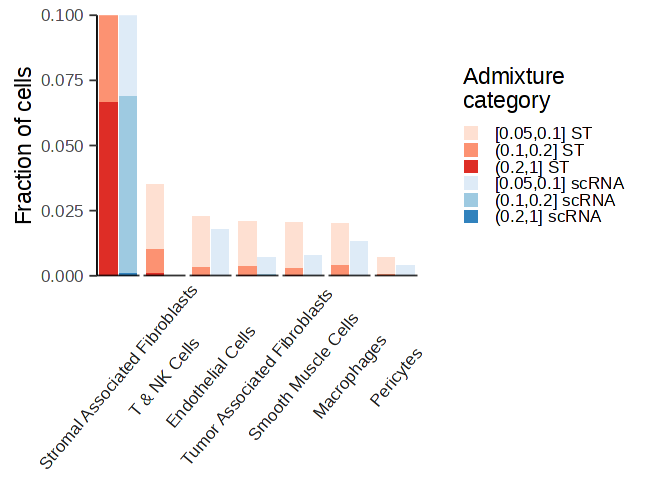

In [14]:
options(repr.plot.width = 3.25, repr.plot.height = 2.5, repr.plot.res = 200)
p <- plotAdmixtureComparison(p_df)
p <- p+coord_cartesian(ylim = c(0, .1))
p

In [15]:
pdf(OutputPath("oc_prevalence_dsamp.pdf"), useDingbats=FALSE, width=3, height=2.5)
p
dev.off()

png 
  2